# Amazon Fine Food Reviews Analysis - Support Vector Machine


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from scipy.stats import uniform
from scipy.sparse import csr_matrix
from collections import Counter

from prettytable import PrettyTable

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

('Number of data points in our data', (525814, 10))


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [10]:
#Deduplication of entries
#final=sorted_data.drop_duplicates(subset={"Score"}, keep='first', inplace=False)
#final.shape

final_pos_reviews=final.loc[final['Score'] == 1]
final_neg_reviews=final.loc[final['Score']== 0]

In [11]:
final=final.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=final.sort_values('Time')
final_new=final[:80000]
final=final_new
new_labels=final['Score']

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [12]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

8
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ksumanth01/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

set([u'all', u'just', u"don't", u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'o', u'don', u'hadn', u'herself', u'll', u'had', u'should', u'to', u'only', u'won', u'under', u'ours', u'has', u"should've", u"haven't", u'do', u'them', u'his', u'very', u"you've", u'they', u'not', u'during', u'now', u'him', u'nor', u"wasn't", u'd', u'did', u'didn', u'this', u'she', u'each', u'further', u"won't", u'where', u"mustn't", u"isn't", u'few', u'because', u"you'd", u'doing', u'some', u'hasn', u"hasn't", u'are', u'our', u'ourselves', u'out', u'what', u'for', u"needn't", u'below', u're', u'does', u"shouldn't", u'above', u'between', u'mustn', u't', u'be', u'we', u'who', u"mightn't", u"doesn't", u'were', u'here', u'shouldn', u'hers', u"aren't", u'by', u'on', u'about', u'couldn', u'of', u"wouldn't", u'against', u's', u'isn', u'or', u'own', u'into', u'yourself', u'down', u"hadn't", u'mightn', u"couldn't", u'wasn', u'your', u"you're", u'from', u'her', u'their', u'aren', u"it's",

In [15]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [16]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

# Bag of Words - Unigrams

In [17]:
# Dividing raw train and test data
X = final['CleanedText']
y = np.array(new_labels)

X_train = X[:int(0.7*len(X))]
y_train = y[:int(0.7*len(y))]
X_test = X[len(X_train):]
y_test = y[len(y_train):]

In [18]:
# Applying bow on train data
count_vect = CountVectorizer()
train_final = count_vect.fit_transform(X_train)
print(type(train_final))
print("Train data shape: ",train_final.get_shape())

# Standardizing X_train data
# Create the Scaler object
scaler = preprocessing.StandardScaler(with_mean=False)
# Fit your data on the scaler object
standardized_Xtrain = scaler.fit_transform(train_final)

test_final = count_vect.transform(X_test)   # applying bow on test data
print("Test data shape: ",test_final.get_shape())

standardized_Xtest = scaler.transform(test_final)   # Standardizing X_test data

<class 'scipy.sparse.csr.csr_matrix'>
('Train data shape: ', (56000, 28263))
('Test data shape: ', (24000, 28263))


## LinearSVC

In [20]:
%%time
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn import linear_model


hyperparam_Xdata=standardized_Xtrain[:10000]
hyperparam_Ydata=y_train[:10000]
param_grid = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]}
sgd = linear_model.SGDClassifier(loss='hinge',class_weight='balanced')
clf = GridSearchCV(sgd, param_grid, cv=3, n_jobs=-1,scoring='f1_weighted')
clf.fit(standardized_Xtrain,y_train)
print clf.best_estimator_

SGDClassifier(alpha=1.0, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
CPU times: user 3.53 s, sys: 362 ms, total: 3.89 s
Wall time: 5.04 s


In [32]:
cvresults=clf.cv_results_
train_score=list(cvresults['std_train_score'])
cv_score=list(cvresults['std_test_score'])
alpha=[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]

alph=alpha[cv_score.index(min(cv_score))]
print "Lowest error is found for alpha= ",alph

Lowest error is found for alpha=  1.0


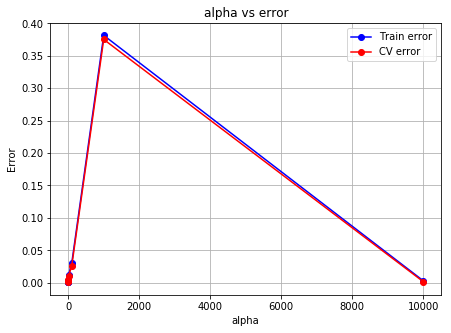

In [33]:
plt.figure(figsize=(7,5))
plt.plot( alpha, train_score, linestyle='-', marker='o',color="blue")
plt.plot( alpha, cv_score, linestyle='-', marker='o',color="red")
plt.title('alpha vs error')
plt.legend(['Train error','CV error'])
plt.xlabel('alpha')
plt.ylabel('Error')
plt.grid(True)

('Training Score : ', 94.59646487629702)
('Training Error : ', 5.40353512370298)
('Test Score : ', 89.82536715137077)
('Test Error : ', 10.17463284862923)
Train confusion matrix:
[[ 5861   508]
 [ 2720 46911]]
Test confusion matrix:
[[ 2459   768]
 [ 1822 18951]]


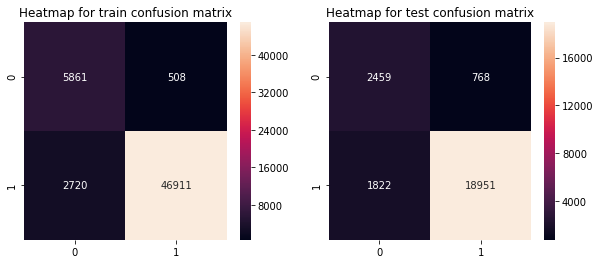

In [50]:
# Training model with X_train and prediction for X_test
clf1 = linear_model.SGDClassifier(loss='hinge',alpha=alph,class_weight='balanced')
clf1.fit(standardized_Xtrain,y_train)

pred1 = clf1.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred1,average='weighted') * 100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf1.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion1 = confusion_matrix(y_train,pred1)
print ("Train confusion matrix:")
print (confusion1)

confusion = confusion_matrix(y_test, pred)
print ("Test confusion matrix:")
print (confusion)

import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
tr=sns.heatmap(confusion1, ax=ax1, annot=True,fmt="d")
tr.set_title('Heatmap for train confusion matrix')
ts=sns.heatmap(confusion, ax=ax2,annot=True,fmt="d")
ts.set_title('Heatmap for test confusion matrix')
plt.show()

### Obtaining top positive and negative features

(-0.5, 799.5, 799.5, -0.5)

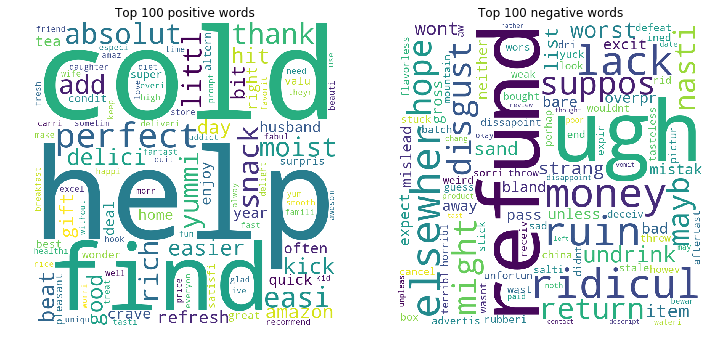

In [55]:
weight_vector=clf1.coef_[0]
words_list=count_vect.get_feature_names()
j=sorted(weight_vector,reverse=True)

pos_indexes=[list(weight_vector).index(i) for i in j[:100]]
pos_words=[words_list[i] for i in pos_indexes]
comment_words = ' '
for i in pos_words:
    comment_words = comment_words + i + ' '
    
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
pos_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

neg_indexes=[list(weight_vector).index(i) for i in j[-100:]]
neg_words=[words_list[i] for i in neg_indexes]
neg_words.reverse()
comment_words = ' '
for i in neg_words:
    comment_words = comment_words + i + ' '
    
neg_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)


# plot the WordCloud image
fig = plt.figure(figsize=(12,12),facecolor=None)
ax = fig.add_subplot(1,2,1)
ax.imshow(pos_wordcloud)
tit='Top 100 positive words'
ax.set_title(tit)
ax.axis('off')

ax = fig.add_subplot(1,2,2)
ax.imshow(neg_wordcloud)
tit='Top 100 negative words'
ax.set_title(tit)
ax.axis('off')

## RBF kernel

### Finding best hyperparameters using GridSearchCV 

In [20]:
from sklearn.svm import SVC
#svd on train data
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
svd_Xtrain=svd.fit_transform(standardized_Xtrain)

#svd on test data
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
svd_Xtest=svd.fit_transform(standardized_Xtest)
print svd_Xtrain.shape
print svd_Xtest.shape

(56000, 300)
(24000, 300)


In [25]:
%%time
hyperparam_Xdata=svd_Xtrain[:10000]
hyperparam_Ydata=y_train[:10000]
param_grid = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
svc = SVC( kernel='rbf',random_state=5,class_weight='balanced')
clf = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1,scoring='f1_weighted')
clf.fit(hyperparam_Xdata,hyperparam_Ydata)
print clf.best_estimator_

/home/ksumanth01/.local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=5, shrinking=True,
  tol=0.001, verbose=False)
CPU times: user 47.8 s, sys: 542 ms, total: 48.3 s
Wall time: 1h 9min 28s


In [26]:
cvresults=clf.cv_results_
score=cvresults['std_test_score']
cv_score=np.array(score)
params=np.split(cv_score,8)

Text(96,0.5,'gamma values')

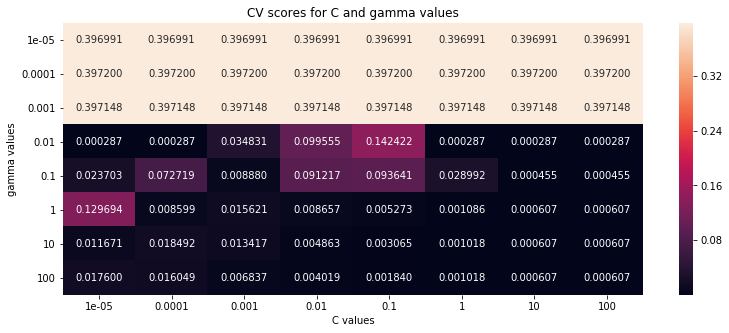

In [27]:
import seaborn as sns
labels=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
ax = plt.subplots(figsize=(13,5))      
ax = sns.heatmap(params,annot=True,xticklabels=labels,yticklabels=labels,fmt="f")
plt.title('CV scores for C and gamma values')
plt.xlabel('C values')
plt.ylabel('gamma values')

GridSearchCV
('Best C : ', 10)
('Best gamma : ', 0.01)
('Training Score : ', 94.7923501829246)
('Training Error : ', 5.207649817075406)
('Test Score : ', 67.66531958987962)
('Test Error : ', 32.334680410120384)
Confusion Matrix:
[[  805  2422]
 [ 6609 14164]]
CPU times: user 1h 32min 31s, sys: 475 ms, total: 1h 32min 31s
Wall time: 1h 32min 31s


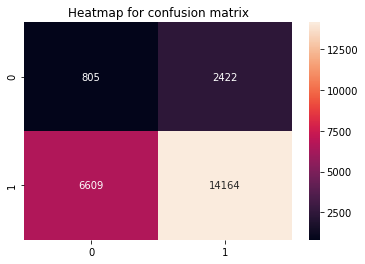

In [21]:
%%time
print("GridSearchCV")
# Obtaining best C
best_C = clf.best_estimator_.get_params()['C']
print ("Best C : ",best_C)
# Obtaining best gamma
best_gamma = clf.best_estimator_.get_params()['gamma']
print ("Best gamma : ",best_gamma)

# Training model with X_train and prediction for X_test
clf1 =SVC(kernel='rbf',C=best_C,gamma=best_gamma,random_state=5,class_weight='balanced')
clf1.fit(svd_Xtrain,y_train)

pred = clf1.predict(svd_Xtrain)
training_score = f1_score(y_train,pred,average='weighted') * 100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf1.predict(svd_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion Matrix:")
print (confusion)
import seaborn as sns
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')

# TF-IDF Featurization

In [56]:
# Dividing raw train and test data
X = final['CleanedText']
y = np.array(new_labels)

X_train = X[:int(0.7*len(X))]
y_train = y[:int(0.7*len(y))]
X_test = X[len(X_train):]
y_test = y[len(y_train):]

In [57]:
# TF-IDF Vectorizing
# vectorizing X_train
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
train_final_tfidf = tf_idf_vect.fit_transform(X_train)

#vectorizing X_test
test_final_tfidf = tf_idf_vect.transform(X_test) 

# Standardizing X_train data
# Create the Scaler object
scaler = preprocessing.StandardScaler(with_mean=False)
# Fit data on the scaler object
standardized_Xtrain = scaler.fit_transform(train_final_tfidf)

# Standardizing X_test data
standardized_Xtest = scaler.transform(test_final_tfidf)
print standardized_Xtrain.shape
print standardized_Xtest.shape

(56000, 774348)
(24000, 774348)


## LinearSVC

In [58]:
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.datasets import make_classification
from sklearn.calibration import CalibratedClassifierCV

hyperparam_Xdata=standardized_Xtrain[:10000]
hyperparam_Ydata=y_train[:10000]
param_grid = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]}
sgd = linear_model.SGDClassifier(loss='hinge',class_weight='balanced')
clf = GridSearchCV(sgd, param_grid, cv=3, n_jobs=-1,scoring='f1_weighted')
clf.fit(standardized_Xtrain,y_train)
print clf.best_estimator_

SGDClassifier(alpha=100.0, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


In [59]:
cvresults=clf.cv_results_
train_score=list(cvresults['std_train_score'])
cv_score=list(cvresults['std_test_score'])
alpha=[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]

alph=alpha[cv_score.index(min(cv_score))]
print "Lowest error is found for alpha= ",alph

Lowest error is found for alpha=  10000.0


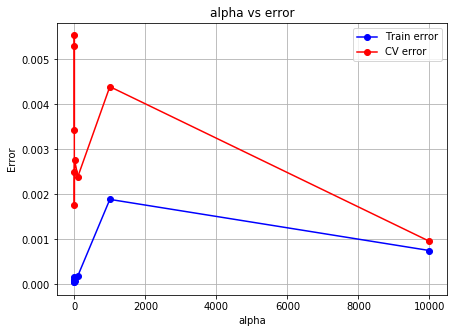

In [60]:
plt.figure(figsize=(7,5))
plt.plot( alpha, train_score, linestyle='-', marker='o',color="blue")
plt.plot( alpha, cv_score, linestyle='-', marker='o',color="red")
plt.title('alpha vs error')
plt.legend(['Train error','CV error'])
plt.xlabel('alpha')
plt.ylabel('Error')
plt.grid(True)

('Training Score : ', 98.94511649477926)
('Training Error : ', 1.0548835052207437)
('Test Score : ', 84.28006262738782)
('Test Error : ', 15.71993737261218)
Train confusion matrix:
[[ 6356    13]
 [  589 49042]]
Test confusion matrix:
[[ 2652   575]
 [ 3727 17046]]


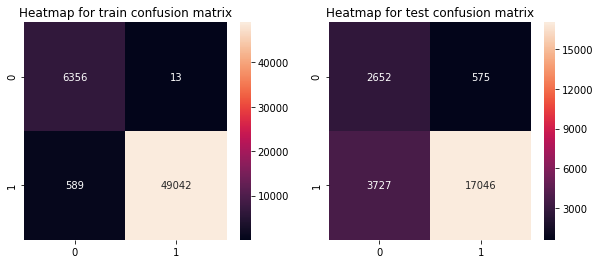

In [61]:
# Training model with X_train and prediction for X_test
clf1 = linear_model.SGDClassifier(loss='hinge',alpha=alph,class_weight='balanced')
clf1.fit(standardized_Xtrain,y_train)

pred1 = clf1.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred1,average='weighted') * 100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf1.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion1 = confusion_matrix(y_train,pred1)
print ("Train confusion matrix:")
print (confusion1)

confusion = confusion_matrix(y_test, pred)
print ("Test confusion matrix:")
print (confusion)

import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
tr=sns.heatmap(confusion1, ax=ax1, annot=True,fmt="d")
tr.set_title('Heatmap for train confusion matrix')
ts=sns.heatmap(confusion, ax=ax2,annot=True,fmt="d")
ts.set_title('Heatmap for test confusion matrix')
plt.show()

### Obtaining top positive and negative features

(-0.5, 799.5, 799.5, -0.5)

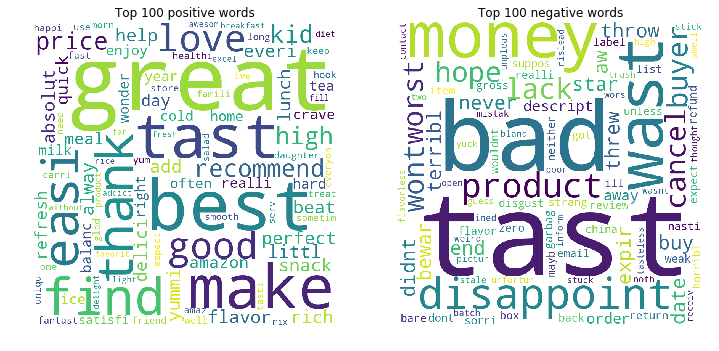

In [62]:
weight_vector=clf1.coef_[0]
words_list=tf_idf_vect.get_feature_names()
j=sorted(weight_vector,reverse=True)

pos_indexes=[list(weight_vector).index(i) for i in j[:100]]
pos_words=[words_list[i] for i in pos_indexes]
comment_words = ' '
for i in pos_words:
    comment_words = comment_words + i + ' '
    
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
pos_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

neg_indexes=[list(weight_vector).index(i) for i in j[-100:]]
neg_words=[words_list[i] for i in neg_indexes]
neg_words.reverse()
comment_words = ' '
for i in neg_words:
    comment_words = comment_words + i + ' '
    
neg_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)


# plot the WordCloud image
fig = plt.figure(figsize=(12,12),facecolor=None)
ax = fig.add_subplot(1,2,1)
ax.imshow(pos_wordcloud)
tit='Top 100 positive words'
ax.set_title(tit)
ax.axis('off')

ax = fig.add_subplot(1,2,2)
ax.imshow(neg_wordcloud)
tit='Top 100 negative words'
ax.set_title(tit)
ax.axis('off')

## RBF kernel

### GridSearchCV 

In [29]:
from sklearn.svm import SVC
#svd on train data
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
svd_Xtrain=svd.fit_transform(standardized_Xtrain)

#svd on test data
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
svd_Xtest=svd.fit_transform(standardized_Xtest)
print svd_Xtrain.shape
print svd_Xtest.shape

(56000, 300)
(24000, 300)


In [30]:
%%time
hyperparam_Xdata=svd_Xtrain[:10000]
hyperparam_Ydata=y_train[:10000]
param_grid = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
svc = SVC( kernel='rbf',random_state=5,class_weight={0:89,1:11})
clf = GridSearchCV(svc, param_grid, cv=3, n_jobs=-1,scoring='f1_weighted')
clf.fit(hyperparam_Xdata,hyperparam_Ydata)
print clf.best_estimator_

SVC(C=0.1, cache_size=200, class_weight={0: 89, 1: 11}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=5, shrinking=True,
  tol=0.001, verbose=False)
CPU times: user 1min 28s, sys: 981 ms, total: 1min 29s
Wall time: 29min 30s


In [31]:
cvresults=clf.cv_results_
score=cvresults['std_test_score']
cv_score=np.array(score)
params=np.split(cv_score,8)

Text(96,0.5,'gamma values')

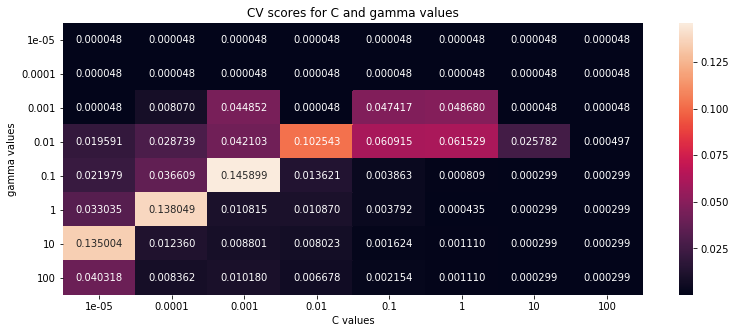

In [32]:
import seaborn as sns
labels=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
ax = plt.subplots(figsize=(13,5))      
ax = sns.heatmap(params,annot=True,xticklabels=labels,yticklabels=labels,fmt="f")
plt.title('CV scores for C and gamma values')
plt.xlabel('C values')
plt.ylabel('gamma values')

GridSearchCV
('Best C : ', 0.1)
('Best gamma : ', 1)
('Training Score : ', 99.22917528252756)
('Training Error : ', 0.7708247174724363)
('Test Score : ', 79.49067616475661)
('Test Error : ', 20.509323835243393)
Confusion Matrix:
[[   44  3183]
 [  577 20196]]
CPU times: user 3h 15min 44s, sys: 466 ms, total: 3h 15min 44s
Wall time: 3h 15min 45s


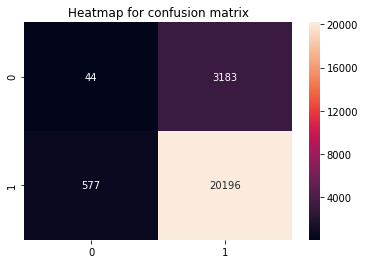

In [33]:
%%time
print("GridSearchCV")
# Obtaining best C
best_C = clf.best_estimator_.get_params()['C']
print ("Best C : ",best_C)
# Obtaining best gamma
best_gamma = clf.best_estimator_.get_params()['gamma']
print ("Best gamma : ",best_gamma)

# Training model with X_train and prediction for X_test
clf1 =SVC(kernel='rbf',C=best_C,gamma=best_gamma,random_state=5,class_weight={0:89,1:11})
clf1.fit(svd_Xtrain,y_train)

pred = clf1.predict(svd_Xtrain)
training_score = f1_score(y_train,pred,average='weighted') * 100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf1.predict(svd_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion Matrix:")
print (confusion)
import seaborn as sns
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')

#  Word2Vec Featurization

In [17]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need
is_your_ram_gt_16g=False
want_to_read_sub_set_of_google_w2v = True
want_to_read_whole_google_w2v = True
if not is_your_ram_gt_16g:
    if want_to_read_sub_set_of_google_w2v and  os.path.isfile('google_w2v_for_amazon.pkl'):
        with open('google_w2v_for_amazon.pkl', 'rb') as f:
            # model is dict object, you can directly access any word vector using model[word]
            model = pickle.load(f)
else:
    if want_to_read_whole_google_w2v and os.path.isfile('GoogleNews-vectors-negative300.bin'):
        model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# print("the vector representation of word 'computer'",model.wv['computer'])
# print("the similarity between the words 'woman' and 'man'",model.wv.similarity('woman', 'man'))
# print("the most similar words to the word 'woman'",model.wv.most_similar('woman'))
# this will raise an error
# model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

## Average W2V

In [18]:
# Dividing raw train and test data
X = final['CleanedText']
y = np.array(new_labels)

X_train = X[:int(0.7*len(X))]
y_train = y[:int(0.7*len(y))]
X_test = X[len(X_train):]
y_test = y[len(y_train):]

In [19]:
# Training Word2Vec model using own text corpus
list_of_sent1=[]
for sent in X_train:
    list_of_sent1.append(sent.split())

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent1,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

('number of words that occured minimum 5 times ', 9701)
('sample words ', [u'woodi', u'yellow', u'interchang', u'four', u'cherrio', u'overprocess', u'decaffin', u'lord', u'digit', u'deli', u'figi', u'furikak', u'foul', u'disturb', u'prize', u'broiler', u'wooden', u'showcas', u'pingshui', u'wednesday', u'superfood', u'unpronounc', u'cheeto', u'tumer', u'rustl', u'miller', u'seper', u'millet', u'second', u'fece', u'sooth', u'bbqd', u'lucious', u'captain', u'thunder', u'succumb', u'ongo', u'avers', u'hero', u'avert', u'jarrow', u'herb', u'splinter', u'cosequin', u'accus', u'here', u'herd', u'china', u'dorm', u'doro'])


In [20]:
# Vectorizing and standardizing X_train 
# compute average word2vec for each review.
train_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent1): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_sent_vectors.append(sent_vec)
train_sent_vectors=csr_matrix(train_sent_vectors)

# Standardizing X_train data
scaler = preprocessing.StandardScaler(with_mean=False)
standardized_Xtrain = scaler.fit_transform(train_sent_vectors)

100%|██████████| 56000/56000 [08:51<00:00, 105.41it/s]


In [21]:
# vectorzing and standardizing X_test
i=0
list_of_sent1=[]
for sent in X_test:
    list_of_sent1.append(sent.split())
    
    
# average Word2Vec
# compute average word2vec for each review.
test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent1): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_sent_vectors.append(sent_vec)
test_sent_vectors=csr_matrix(test_sent_vectors)


# Standardizing X_test data
standardized_Xtest = scaler.transform(test_sent_vectors)

100%|██████████| 24000/24000 [04:05<00:00, 97.70it/s] 


## LinearSVC

In [26]:
%%time
from sklearn.svm import LinearSVC
from sklearn import linear_model

hyperparam_Xdata=standardized_Xtrain[:10000]
hyperparam_Ydata=y_train[:10000]
param_grid = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]}
sgd = linear_model.SGDClassifier(loss='hinge',class_weight='balanced')
clf = GridSearchCV(sgd, param_grid, cv=3, n_jobs=-1,scoring='f1_weighted')
clf.fit(standardized_Xtrain,y_train)
print clf.best_estimator_

SGDClassifier(alpha=1000.0, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
CPU times: user 3.58 s, sys: 108 ms, total: 3.68 s
Wall time: 3.95 s


In [27]:
cvresults=clf.cv_results_
train_score=list(cvresults['std_train_score'])
cv_score=list(cvresults['std_test_score'])
alpha=[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]

alph=alpha[cv_score.index(min(cv_score))]
print "Lowest error is found for alpha= ",alph

Lowest error is found for alpha=  0.0001


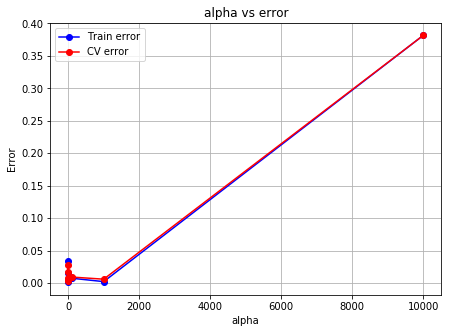

In [28]:
plt.figure(figsize=(7,5))
plt.plot( alpha, train_score, linestyle='-', marker='o',color="blue")
plt.plot( alpha, cv_score, linestyle='-', marker='o',color="red")
plt.title('alpha vs error')
plt.legend(['Train error','CV error'])
plt.xlabel('alpha')
plt.ylabel('Error')
plt.grid(True)

('Training Score : ', 88.60236639868062)
('Training Error : ', 11.397633601319384)
('Test Score : ', 87.30631635639706)
('Test Error : ', 12.693683643602938)
Train confusion matrix:
[[ 2827  3542]
 [ 2631 47000]]
Test confusion matrix:
[[ 1452  1775]
 [ 1133 19640]]


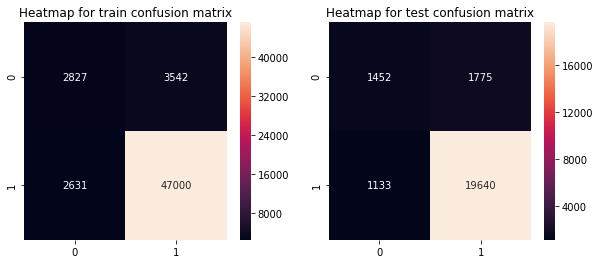

In [29]:
# Training model with X_train and prediction for X_test
clf1 = linear_model.SGDClassifier(loss='hinge',alpha=alph,class_weight='balanced')
clf1.fit(standardized_Xtrain,y_train)

pred1 = clf1.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred1,average='weighted') * 100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf1.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion1 = confusion_matrix(y_train,pred1)
print ("Train confusion matrix:")
print (confusion1)

confusion = confusion_matrix(y_test, pred)
print ("Test confusion matrix:")
print (confusion)

import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
tr=sns.heatmap(confusion1, ax=ax1, annot=True,fmt="d")
tr.set_title('Heatmap for train confusion matrix')
ts=sns.heatmap(confusion, ax=ax2,annot=True,fmt="d")
ts.set_title('Heatmap for test confusion matrix')
plt.show()

## RBF kernel

### GridSearchCV 

In [40]:
%%time
from sklearn.svm import SVC
hyperparam_Xdata=standardized_Xtrain[:10000]
hyperparam_Ydata=y_train[:10000]
param_grid = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
svc = SVC( kernel='rbf',random_state=5,class_weight={0:66,1:44})
clf = GridSearchCV(svc, param_grid, cv=3, n_jobs=-1,scoring='f1_weighted')
clf.fit(hyperparam_Xdata,hyperparam_Ydata)
print clf.best_estimator_

SVC(C=0.1, cache_size=200, class_weight={0: 66, 1: 44}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=5, shrinking=True,
  tol=0.001, verbose=False)
CPU times: user 23.6 s, sys: 300 ms, total: 23.9 s
Wall time: 6min 55s


In [44]:
cvresults=clf.cv_results_
score=cvresults['std_test_score']
cv_score=np.array(score)
params=np.split(cv_score,8)


Text(96,0.5,'gamma values')

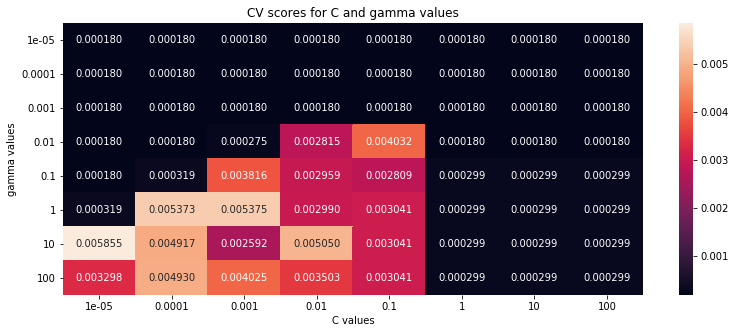

In [45]:
import seaborn as sns
labels=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
ax = plt.subplots(figsize=(13,5))      
ax = sns.heatmap(params,annot=True,xticklabels=labels,yticklabels=labels,fmt="f")
plt.title('CV scores for C and gamma values')
plt.xlabel('C values')
plt.ylabel('gamma values')

GridSearchCV
('Best C : ', 0.1)
('Best gamma : ', 0.01)
('Training Score : ', 92.94066007154042)
('Training Error : ', 7.059339928459579)
('Test Score : ', 90.01421054317483)
('Test Error : ', 9.985789456825174)
Confusion Matrix:
[[ 1625  1602]
 [  621 20152]]
CPU times: user 22min 17s, sys: 0 ns, total: 22min 17s
Wall time: 22min 17s


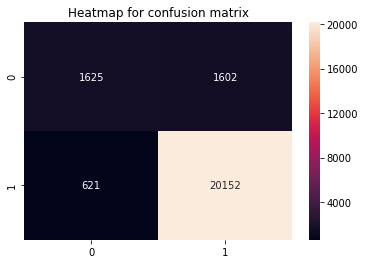

In [47]:
%%time
print("GridSearchCV")
# Obtaining best C
best_C = clf.best_estimator_.get_params()['C']
print ("Best C : ",best_C)
# Obtaining best gamma
best_gamma = clf.best_estimator_.get_params()['gamma']
print ("Best gamma : ",best_gamma)

# Training model with X_train and prediction for X_test
clf1 =SVC(kernel='rbf',C=best_C,gamma=best_gamma,random_state=5,class_weight={0:66,1:44})
clf1.fit(standardized_Xtrain,y_train)

pred = clf1.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred,average='weighted') * 100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf1.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion Matrix:")
print (confusion)
import seaborn as sns
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')

# TF-IDF weighted W2V

In [30]:
# Dividing raw train and test data
X = final['CleanedText']
y = np.array(new_labels)

X_train = X[:int(0.7*len(X))]
y_train = y[:int(0.7*len(y))]
X_test = X[len(X_train):]
y_test = y[len(y_train):]

In [31]:
# Vectorizing and Standardizing X_train

list_of_sent1=[]
for sent in X_train:
    list_of_sent1.append(sent.split())
    
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)


# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1
    
train_sent_vectors=csr_matrix(train_tfidf_sent_vectors)

# Standardizing X_train data
scaler = preprocessing.StandardScaler(with_mean=False)
standardized_Xtrain = scaler.fit_transform(train_sent_vectors)

100%|██████████| 56000/56000 [09:21<00:00, 99.73it/s] 


In [32]:
# Vectorizing and Standardizing X_test
list_of_sent=[]
for sent in X_test:
    list_of_sent.append(sent.split())
    

tf_idf_matrix = model.transform(X_test)

test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1
    
test_sent_vectors=csr_matrix(test_tfidf_sent_vectors)

# Standardizing X_test data
standardized_Xtest = scaler.transform(test_sent_vectors)

100%|██████████| 24000/24000 [04:06<00:00, 97.47it/s] 


## LinearSVC

In [37]:
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.datasets import make_classification
from sklearn.calibration import CalibratedClassifierCV

hyperparam_Xdata=standardized_Xtrain[:10000]
hyperparam_Ydata=y_train[:10000]
param_grid = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]}
sgd = linear_model.SGDClassifier(loss='hinge',class_weight='balanced')
clf = GridSearchCV(sgd, param_grid, cv=3, n_jobs=-1,scoring='f1_weighted')
clf.fit(standardized_Xtrain,y_train)
print clf.best_estimator_

SGDClassifier(alpha=1000.0, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


In [38]:
cvresults=clf.cv_results_
train_score=list(cvresults['std_train_score'])
cv_score=list(cvresults['std_test_score'])
alpha=[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]

alph=alpha[cv_score.index(min(cv_score))]
print "Lowest error is found for alpha= ",alph

Lowest error is found for alpha=  0.1


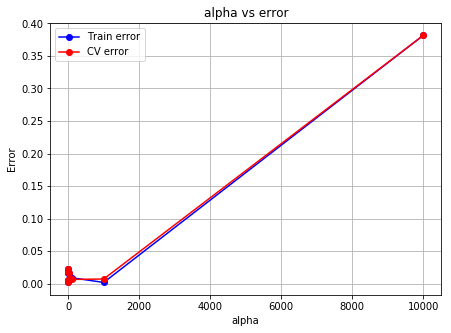

In [39]:
plt.figure(figsize=(7,5))
plt.plot( alpha, train_score, linestyle='-', marker='o',color="blue")
plt.plot( alpha, cv_score, linestyle='-', marker='o',color="red")
plt.title('alpha vs error')
plt.legend(['Train error','CV error'])
plt.xlabel('alpha')
plt.ylabel('Error')
plt.grid(True)

('Training Score : ', 78.807113732515)
('Training Error : ', 21.192886267484994)
('Test Score : ', 77.95230736402637)
('Test Error : ', 22.047692635973632)
Train confusion matrix:
[[ 5284  1085]
 [13293 36338]]
Test confusion matrix:
[[ 2703   524]
 [ 5712 15061]]


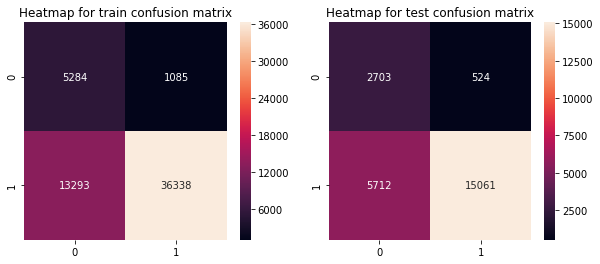

In [40]:
# Training model with X_train and prediction for X_test
clf1 = linear_model.SGDClassifier(loss='hinge',alpha=alph,class_weight='balanced')
clf1.fit(standardized_Xtrain,y_train)

pred1 = clf1.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred1,average='weighted') * 100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf1.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion1 = confusion_matrix(y_train,pred1)
print ("Train confusion matrix:")
print (confusion1)

confusion = confusion_matrix(y_test, pred)
print ("Test confusion matrix:")
print (confusion)

import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
tr=sns.heatmap(confusion1, ax=ax1, annot=True,fmt="d")
tr.set_title('Heatmap for train confusion matrix')
ts=sns.heatmap(confusion, ax=ax2,annot=True,fmt="d")
ts.set_title('Heatmap for test confusion matrix')
plt.show()

## RBF kernel

### GridSearchCV 

In [123]:
%%time
hyperparam_Xdata=standardized_Xtrain[:10000]
hyperparam_Ydata=y_train[:10000]
param_grid = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
svc = SVC( kernel='rbf',random_state=5,class_weight={0:68,1:32})
clf = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1,scoring='f1_weighted')
clf.fit(hyperparam_Xdata,hyperparam_Ydata)
print clf.best_estimator_

SVC(C=100, cache_size=200, class_weight={0: 68, 1: 32}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=5, shrinking=True,
  tol=0.001, verbose=False)
CPU times: user 26.5 s, sys: 909 ms, total: 27.4 s
Wall time: 20min 51s


In [124]:
cvresults=clf.cv_results_
score=cvresults['std_test_score']
cv_score=np.array(score)
params=np.split(cv_score,8)
print params

[array([0.00028733, 0.00028733, 0.00028733, 0.00028733, 0.00028733,
       0.00028733, 0.00028733, 0.00028733]), array([0.00028733, 0.00028733, 0.00028733, 0.00028733, 0.00028733,
       0.00028733, 0.00028733, 0.00028733]), array([0.00028733, 0.00028733, 0.00028733, 0.00079931, 0.00028733,
       0.00028733, 0.00028733, 0.00028733]), array([0.00028733, 0.00028733, 0.00195329, 0.01049563, 0.00775856,
       0.00028733, 0.00028733, 0.00028733]), array([0.00028733, 0.00259264, 0.01027311, 0.00930726, 0.00792932,
       0.00060656, 0.00060656, 0.00060656]), array([0.0021169 , 0.00851155, 0.01017703, 0.00711038, 0.00832858,
       0.00060656, 0.00060656, 0.00060656]), array([0.00779263, 0.01054682, 0.00936817, 0.0083845 , 0.00832858,
       0.00060656, 0.00060656, 0.00060656]), array([0.01073904, 0.00980968, 0.0073036 , 0.00683273, 0.00832858,
       0.00060656, 0.00060656, 0.00060656])]


Text(96,0.5,'gamma values')

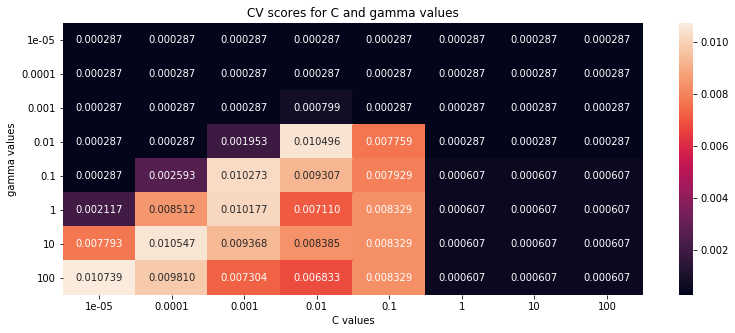

In [125]:
import seaborn as sns
labels=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
ax = plt.subplots(figsize=(13,5))      
ax = sns.heatmap(params,annot=True,xticklabels=labels,yticklabels=labels,fmt="f")
plt.title('CV scores for C and gamma values')
plt.xlabel('C values')
plt.ylabel('gamma values')

GridSearchCV
('Best C : ', 100)
('Best gamma : ', 0.0001)
('Training Score : ', 90.27431405260839)
('Training Error : ', 9.72568594739161)
('Test Score : ', 88.6851916288457)
('Test Error : ', 11.3148083711543)
Confusion Matrix:
[[ 1561  1666]
 [  900 19873]]
CPU times: user 31min 35s, sys: 0 ns, total: 31min 35s
Wall time: 31min 35s


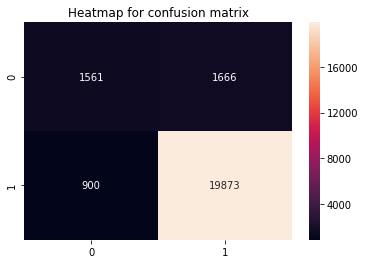

In [126]:
%%time
print("GridSearchCV")
# Obtaining best C
best_C = clf.best_estimator_.get_params()['C']
print ("Best C : ",best_C)
# Obtaining best gamma
best_gamma = clf.best_estimator_.get_params()['gamma']
print ("Best gamma : ",best_gamma)

# Training model with X_train and prediction for X_test
clf1 =SVC(kernel='rbf',C=best_C,gamma=best_gamma,random_state=5,class_weight={0:68,1:32})
clf1.fit(standardized_Xtrain,y_train)

pred = clf1.predict(standardized_Xtrain)
training_score = f1_score(y_train,pred,average='weighted') * 100
training_error = 100-training_score
print ("Training Score : ",training_score)
print ("Training Error : ",training_error)

pred = clf1.predict(standardized_Xtest)
test_score = f1_score(y_test,pred,average='weighted') * 100
test_error = 100-test_score
print ("Test Score : ",test_score)
print ("Test Error : ",test_error)

confusion = confusion_matrix(y_test, pred)
print ("Confusion Matrix:")
print (confusion)
import seaborn as sns
ax = sns.heatmap(confusion, annot=True, fmt="d")
ax.set_title('Heatmap for confusion matrix')

In [41]:
t = PrettyTable()
t.field_names = ["Featurization","Model","alpha","C","gamma","Train error","Test error"]
t.add_row(["Bag of words","Linear SVC",10,"-","-",round(5.40353512370298,4),round(10.17463284862923,4)])
t.add_row(["Bag of words","RBF","-",10, 0.01,round(5.207649817075406,4),round(32.334680410120384,4)])

t.add_row(["TF-IDF","Linear SVC",1.0,"-","-",round(1.0548835052207437,4),round(15.71993737261218,4)])
t.add_row(["TF-IDF","RBF","-",0.1, 1,round(0.7708247174724363,4),round(20.509323835243393,4)])

t.add_row(["Avg W2V","Linear SVC",1.0,"-","-",round(11.397633601319384,4),round(12.693683643602938,4)])
t.add_row(["Avg W2V","RBF","-",0.1, 0.01,round(7.059339928459579,4),round(9.985789456825174,4)])

t.add_row(["TF-IDF weighted W2V","Linear SVC",10.0,"-","-",round(21.192886267484994,4),round(22.047692635973632,4)])
t.add_row(["TF-IDF weighted W2V","RBF","-",100,0.0001,round(9.72568594739161,4),round(11.3148083711543,4)])

In [42]:
print t

+---------------------+------------+-------+-----+--------+-------------+------------+
|    Featurization    |   Model    | alpha |  C  | gamma  | Train error | Test error |
+---------------------+------------+-------+-----+--------+-------------+------------+
|     Bag of words    | Linear SVC |   10  |  -  |   -    |    5.4035   |  10.1746   |
|     Bag of words    |    RBF     |   -   |  10 |  0.01  |    5.2076   |  32.3347   |
|        TF-IDF       | Linear SVC |  1.0  |  -  |   -    |    1.0549   |  15.7199   |
|        TF-IDF       |    RBF     |   -   | 0.1 |   1    |    0.7708   |  20.5093   |
|       Avg W2V       | Linear SVC |  1.0  |  -  |   -    |   11.3976   |  12.6937   |
|       Avg W2V       |    RBF     |   -   | 0.1 |  0.01  |    7.0593   |   9.9858   |
| TF-IDF weighted W2V | Linear SVC |  10.0 |  -  |   -    |   21.1929   |  22.0477   |
| TF-IDF weighted W2V |    RBF     |   -   | 100 | 0.0001 |    9.7257   |  11.3148   |
+---------------------+------------+-------

From the above table we can infer that the lowest train error is observed as 0.7708 for TF-IDF featurization with RBF model and its corresponding test error is 20.5093. The lowest test error is observed as 9.9859 for the featurization Avg w2v with RBF kernel and its corresponding train error is 7.0593. Out of all featurizations and all models, Avg w2v seems to be the best considering its error rates. Its corresponding c is 0.1 and gamma is 0.01.